# Aplicar Prophet sobre los datos limpios

**Autor:** Juan Manuel Martínez Estrada  
**Fecha:** 2025-06-05  
**Versión:** 1.0  

---

# 1. Configuración del Entorno y Rutas

---

* Importación de Librerías

In [444]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error


* Importación de Librerías Personalizadas

In [445]:
import sys
import os
sys.path.append(os.path.abspath('..'))
import src.train_prophet_models as tpm
import src.data as data

* Configuración Global

In [446]:
# Configración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

* Rutas

In [447]:
data_path = os.path.join('..', '..', '01_data_preparation', 'data', 'processed', 'dataset_processed.csv') 

* Cargando el dataset en un DataFrame de pandas

In [448]:
df = data.cargar_datos(data_path)

consumption_columns = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant', 'Biomass Losses and Co-products',
    'Biomass Energy', 'Renewable Diesel Fuel',
    'Other Biofuels', 'Conventional Hydroelectric Power', 'Biodiesel' 
]
df = df.groupby(['datetime'])
df = df[consumption_columns].sum().reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   datetime                            612 non-null    object 
 1   Hydroelectric Power                 612 non-null    float64
 2   Geothermal Energy                   612 non-null    float64
 3   Solar Energy                        612 non-null    float64
 4   Wind Energy                         612 non-null    float64
 5   Wood Energy                         612 non-null    float64
 6   Waste Energy                        612 non-null    float64
 7   Fuel Ethanol, Excluding Denaturant  612 non-null    float64
 8   Biomass Losses and Co-products      612 non-null    float64
 9   Biomass Energy                      612 non-null    float64
 10  Renewable Diesel Fuel               612 non-null    float64
 11  Other Biofuels                      612 non-n

# 2. Preparación de Datos para Prophet

* Selecciona la Serie Temporal a Pronosticar

In [449]:
target_prophet = 'Wind Energy'

* Definiendo las columnas para Prophet `ds` y `y`

In [450]:
df_prophet_ready = df[['datetime', target_prophet]].copy()
df_prophet_ready.rename(columns={'datetime': 'ds', target_prophet: 'y'}, inplace=True)
df_prophet_ready

,ds,y
0,1973-01-01,0.00
1,1973-02-01,0.00
2,1973-03-01,0.00
3,1973-04-01,0.00
4,1973-05-01,0.00
...,...,...
607,2023-08-01,97.45
608,2023-09-01,96.38
609,2023-10-01,124.56
610,2023-11-01,126.47


* Asegurando que los datos correspondan a los necesarios para Prophet

In [451]:
df_prophet_ready['ds'] = pd.to_datetime(df_prophet_ready['ds'])
df_prophet_ready['y'] = pd.to_numeric(df_prophet_ready['y'])

# 3. División de Datos (Cronológicamente)

In [452]:
num_test_periods = 36 # Meses
train_prophet = df_prophet_ready.iloc[:-num_test_periods]
test_prophet_actuals = df_prophet_ready.iloc[-num_test_periods:]

print(f"Datos de entrenamiento: {len(train_prophet)} periodos, desde {train_prophet['ds'].min()} hasta {train_prophet['ds'].max()}")
print(f"Datos de prueba: {len(test_prophet_actuals)} periodos, desde {test_prophet_actuals['ds'].min()} hasta {test_prophet_actuals['ds'].max()}")

Datos de entrenamiento: 576 periodos, desde 1973-01-01 00:00:00 hasta 2020-12-01 00:00:00
Datos de prueba: 36 periodos, desde 2021-01-01 00:00:00 hasta 2023-12-01 00:00:00


# 4. Instanciación y Entrenamiento del Modelo Prophet

In [453]:
model_prophet = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative', 
        changepoint_prior_scale=0.75, 
        seasonality_prior_scale=10.0
    )

model_prophet.fit(train_prophet)
print("Modelo Prophet entrenado exitosamente.")

19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing


Modelo Prophet entrenado exitosamente.


# 5. Generación de Fechas Futuras para Pronóstico

In [454]:
periods_to_forecast = len(test_prophet_actuals)

future_dates = model_prophet.make_future_dataframe(periods=48, freq='MS')

print("\nÚltimas fechas del historial y primeras fechas futuras generadas:")
print(train_prophet['ds'].tail(3))
print(future_dates.tail(periods_to_forecast + 3)) 


Últimas fechas del historial y primeras fechas futuras generadas:
573   2020-10-01
574   2020-11-01
575   2020-12-01
Name: ds, dtype: datetime64[ns]
            ds
585 2021-10-01
586 2021-11-01
587 2021-12-01
588 2022-01-01
589 2022-02-01
590 2022-03-01
591 2022-04-01
592 2022-05-01
593 2022-06-01
594 2022-07-01
595 2022-08-01
596 2022-09-01
597 2022-10-01
598 2022-11-01
599 2022-12-01
600 2023-01-01
601 2023-02-01
602 2023-03-01
603 2023-04-01
604 2023-05-01
605 2023-06-01
606 2023-07-01
607 2023-08-01
608 2023-09-01
609 2023-10-01
610 2023-11-01
611 2023-12-01
612 2024-01-01
613 2024-02-01
614 2024-03-01
615 2024-04-01
616 2024-05-01
617 2024-06-01
618 2024-07-01
619 2024-08-01
620 2024-09-01
621 2024-10-01
622 2024-11-01
623 2024-12-01


# 6. Realización de Predicciones

In [455]:
forecast = model_prophet.predict(future_dates)

print("\nColumnas del DataFrame de pronóstico ('forecast'):")
print(forecast.columns)
print("\nPrimeras y últimas filas del pronóstico:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


Columnas del DataFrame de pronóstico ('forecast'):
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

Primeras y últimas filas del pronóstico:
          ds  yhat  yhat_lower  yhat_upper
0 1973-01-01 -0.02       -6.06        6.30
1 1973-02-01 -0.02       -5.72        6.16
2 1973-03-01 -0.02       -5.82        5.87
3 1973-04-01 -0.02       -5.76        6.06
4 1973-05-01 -0.02       -6.07        5.90
            ds   yhat  yhat_lower  yhat_upper
619 2024-08-01  89.71       66.71      109.16
620 2024-09-01  95.29       70.56      116.81
621 2024-10-01 122.33       89.07      151.41
622 2024-11-01 131.78       95.74      162.19
623 2024-12-01 131.62       93.99      162.51


# 7. Visualización del Pronóstico

* Gráfico 1: Pronóstico principal

C:\Users\PC\AppData\Local\Temp\ipykernel_14380\3957756147.py:6: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



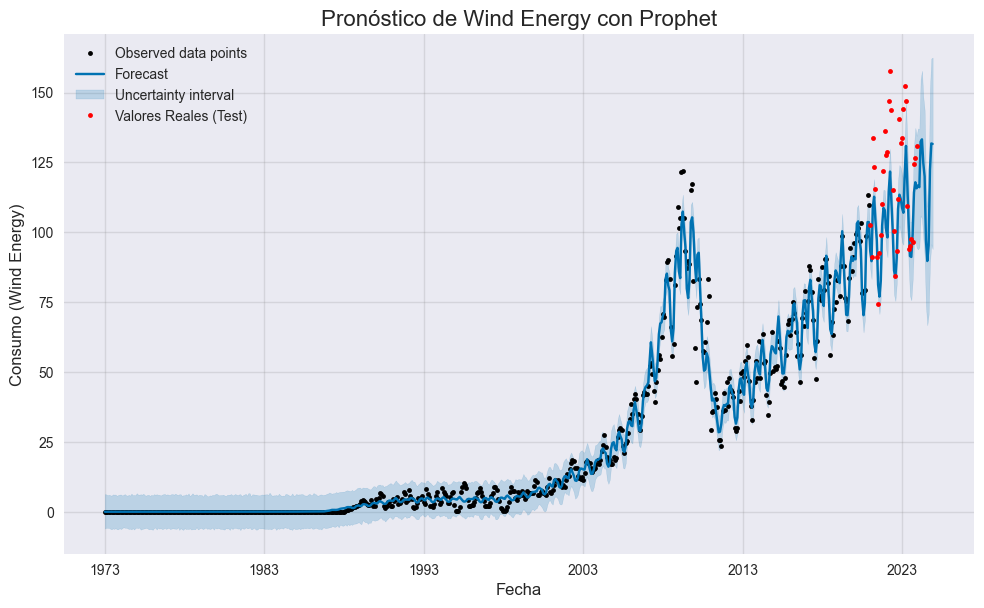

In [456]:
fig1 = model_prophet.plot(forecast, include_legend=True)
plt.title(f'Pronóstico de {target_prophet} con Prophet', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Consumo ({target_prophet})', fontsize=12)
plt.plot(
    test_prophet_actuals['ds'].dt.to_pydatetime(), # Convertir a datetime de python para mejor compatibilidad con matplotlib
    test_prophet_actuals['y'],
    color='red', linestyle='none', label='Valores Reales (Test)' ,marker='.'
)
plt.legend()
plt.show()

* Gráfico 2: Componentes del modelo

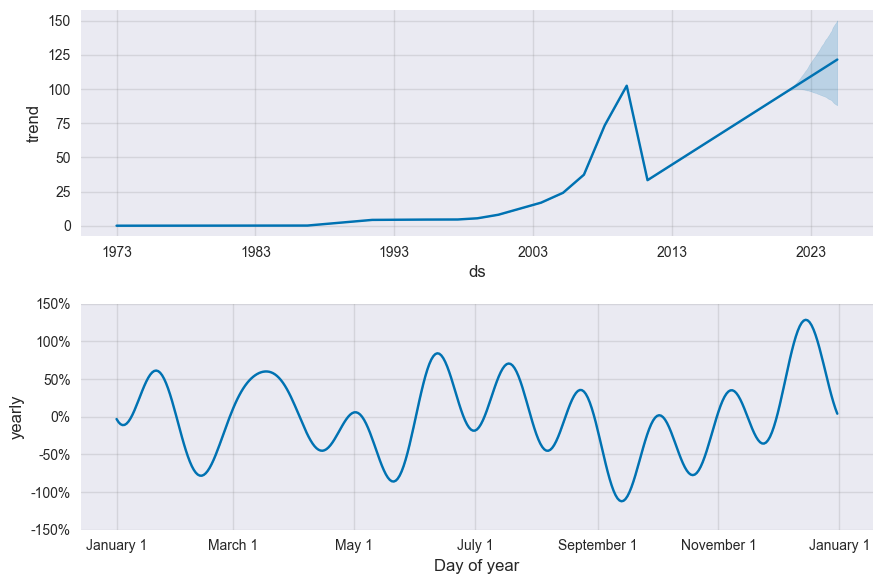

In [457]:
fig2 = model_prophet.plot_components(forecast)
plt.show()

In [458]:
fig_plotly1 = plot_plotly(model_prophet, forecast)
fig_plotly1.show()
fig_plotly2 = plot_components_plotly(model_prophet, forecast)
fig_plotly2.show()

# 8. Evaluar el pronóstico

In [459]:
forecast_on_test_period = forecast[forecast['ds'].isin(test_prophet_actuals['ds'])]
    
eval_df = pd.merge(test_prophet_actuals, forecast_on_test_period[['ds', 'yhat']], on='ds', how='inner')

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
mae_prophet = mean_absolute_error(eval_df['y'], eval_df['yhat'])

# Calcular MAPE (Mean Absolute Percentage Error)
# Evitar división por cero si y_true es 0
mape_prophet = np.mean(np.abs((eval_df['y'] - eval_df['yhat']) / np.where(eval_df['y'] == 0, 1e-6, eval_df['y']))) * 100


print(f"\n--- Métricas de Evaluación para Prophet ({target_prophet}) en el Conjunto de Prueba ---")
print(f"RMSE: {rmse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")
print(f"MAPE: {mape_prophet:.2f}%")

print("\nComparativa de valores reales vs. predichos en prueba:")
print(eval_df[['ds', 'y', 'yhat']].tail())


--- Métricas de Evaluación para Prophet (Wind Energy) en el Conjunto de Prueba ---
RMSE: 19.1268
MAE: 15.7890
MAPE: 12.51%

Comparativa de valores reales vs. predichos en prueba:
           ds      y   yhat
31 2023-08-01  97.45  91.17
32 2023-09-01  96.38  99.31
33 2023-10-01 124.56 114.25
34 2023-11-01 126.47 117.89
35 2023-12-01 130.99 115.72
